# Return Agent

In [1]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase

In [2]:
local_db_path = "../datasets/olist_ecommerce.db"

In [3]:
db = SQLDatabase.from_uri(f"sqlite:///{local_db_path}")

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

In [5]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [6]:
sql_tools = sql_toolkit.get_tools()

In [7]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [8]:
from langchain_core.messages import BaseMessage
from typing import Sequence, Annotated, TypedDict, Literal
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver  

class AgentState(TypedDict):
    """State of the agent. Contains messages, PDF content, and routing info."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    pdf_context: str
    decide_path: Literal["sql_branch", "pdf_branch", "pdf_sql_branch", "general"]


In [9]:
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import MessagesState

def pdf_branch(state: AgentState) -> AgentState:
    print("Running PDF branch...")
    loader = PyPDFLoader("../docs/polar-return-policy.pdf")
    docs = loader.load()
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in docs
    )

    # store the serialized PDF content in the state
    state["pdf_context"] = serialized
    print(f"pdf_context: {state['pdf_context']}")
    return state


In [10]:
# Steps
from typing import Literal

from langgraph.prebuilt import ToolNode
from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph


get_schema_tool = next(tool for tool in sql_tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in sql_tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: AgentState):
    print("list_tables tool")
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in sql_tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")
    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: AgentState):
    print("call_get_schema tool")
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: AgentState):
    print("generate_query tool")
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: AgentState):
    print("check_query tool")
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [11]:
from langchain_core.messages.base import BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

llm_answer = ChatOpenAI(model="gpt-5", temperature=0)

def answer_node(state: AgentState) -> AgentState:
    print("Generating final answer...")
    messages = state["messages"]
    pdf_context = state.get("pdf_context", "")

    system_prompt = "Responda à pergunta do usuário. Use o contexto do PDF se fornecido."

    if pdf_context:
        system_prompt += f"\n\nContexto do PDF:\n{pdf_context}"

    # Use full conversation history so the model has memory
    prompt_messages = [SystemMessage(content=system_prompt)] + list(messages)
    response = llm_answer.invoke(prompt_messages)

    # Append the model's answer to the conversation
    state["messages"].append(response)
    return state


In [12]:
from typing import Literal
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig


llm_router = ChatOpenAI(model="gpt-5", temperature=0)

def decide_path(state: AgentState, config: RunnableConfig) -> Literal["sql_branch", "pdf_branch", "pdf_sql_branch", "general"]:
    print("decide_path tool")
    messages = state["messages"]
    last_message = messages[-1]

    system_prompt = (
        "Você é um router que decide quais tools são necessárias para responder à pergunta do usuário.\n"
        "Saídas possíveis:\n"
        "- 'sql_branch': a pergunta necessita apenas do banco de dados.\n"
        "- 'pdf_branch': a pergunta necessita apenas do PDF.\n"
        "- 'pdf_sql_branch': a pergunta necessita tanto do banco de dados quanto do PDF.\n"
        "- 'general': nenhuma ferramenta necessária.\n\n"
        "Exemplos:\n"
        "- 'Quais clientes pediram mais de 5 itens?' → sql_branch\n"
        "- 'Qual é a política de devolução?' → pdf_branch\n"
        "- 'O pedido e481f51... é elegível para devolução de acordo com a política?' → pdf_sql_branch\n"
        "- 'Quem é você?' → general"
    )

    response = llm_router.invoke([SystemMessage(system_prompt)] + [last_message], config)
    
    decision = response.content.strip().lower()
    print(f"decision: {decision}")

    if decision not in {"sql_branch", "pdf_branch", "pdf_sql_branch", "general"}:
        decision = "general"
    return {"decide_path": decision}



In [13]:
def should_continue(state: AgentState) -> Literal[END, "check_query", "answer"]:
    print("should_continue")
    messages = state["messages"]
    last_message = messages[-1]
    # If the last model output is a plain answer (no tool calls), go to final answer node
    if not getattr(last_message, "tool_calls", None):
        return "answer"
    else:
        return "check_query"


builder = StateGraph(AgentState)

# Add all nodes
builder.add_node("decide_path", decide_path)
builder.add_node("pdf_branch", pdf_branch)
builder.add_node("list_tables", list_tables)
builder.add_node("call_get_schema", call_get_schema)
builder.add_node("get_schema", get_schema_node)
builder.add_node("generate_query", generate_query)
builder.add_node("check_query", check_query)
builder.add_node("run_query", run_query_node)

# Optional: a final answer node that uses PDF/SQL context to respond
builder.add_node("answer", answer_node)

# Add routing edges
builder.add_edge(START, "decide_path")

builder.add_conditional_edges(
    "decide_path",
    lambda state: state["decide_path"],
    {
        "sql_branch": "list_tables",
        "pdf_branch": "pdf_branch",
        "pdf_sql_branch": "pdf_branch",  # then we’ll chain SQL after PDF
        "general": "answer",
    }
)

# --- PDF path ---
# After loading PDF, go either to SQL or directly to answer
builder.add_conditional_edges(
    "pdf_branch",
    lambda state: (
        "list_tables" if state["decide_path"] == "pdf_sql_branch" else "answer"
    ),
    {
        "list_tables": "list_tables",
        "answer": "answer",
    },
)

# Keep your SQL workflow as before
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges("generate_query", should_continue)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

# End of pipeline
builder.add_edge("answer", END)

checkpointer = InMemorySaver()  
agent = builder.compile(checkpointer=checkpointer)

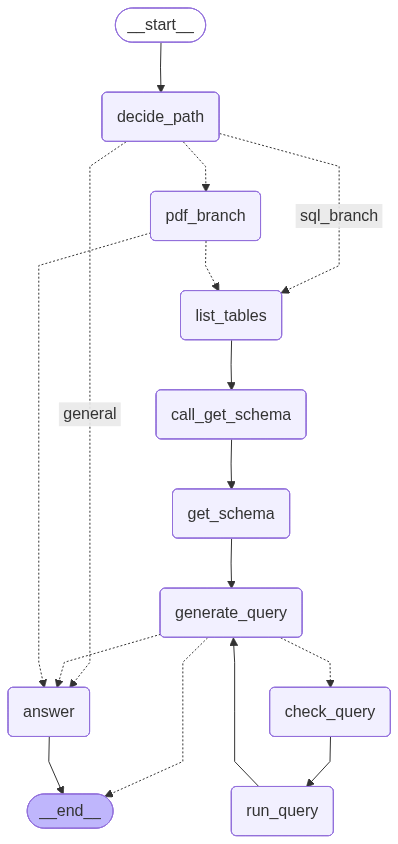

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
pdf_query = "Olá quero saber como funciona a politica de devolucao"
sql_query = "Qual o id do cliente para o pedido 6514b8ad8028c9f2cc2374ded245783f ?"
pdf_sql_query = "Você pode checar se o pedido e481f51cbdc54678b7cc49136f2d6af7 é elegivel para devolucao?"


In [16]:
example_query = pdf_sql_query

In [17]:
# #Helper function for formatting the stream nicely
# def print_stream(stream):
#     for s in stream:
#         message = s["messages"][-1]
#         if isinstance(message, tuple):
#             print(message)
#         else:
#             message.pretty_print()

In [18]:
def print_stream(stream):
    """Pretty print each streamed step and return the final state."""
    last_state = None
    for s in stream:
        last_state = s
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return last_state


In [19]:
config = {"configurable": {"thread_id": "20"}}


In [20]:
# config = {"configurable": {"thread_id": "20"}}
# input_state = {
#     "messages": [{"role": "user", "content": "Summarize the return policy from the PDF"}],
#     "pdf_context": "",
#     "decision": "",
# }
# for step in agent.stream(
#     input_state,
#     stream_mode="values",
#     config=config
# ):
#     step["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "20"}}

while True:
    input_state = {
        "messages": [("user", input())],
        "pdf_context": "",
        "decide_path": "",
    }

    final_state =print_stream(agent.stream(input_state, stream_mode="values", config=config))

    # --- check if workflow reached END ---
    if final_state and getattr(final_state, "_next", None) == END:
        print("\nWorkflow reached END. Exiting loop.")
        break

================================ Human Message =================================

Olá, meu nome é Maria
decide_path tool
decision: general
================================ Human Message =================================

Olá, meu nome é Maria
Generating final answer...
================================== Ai Message ==================================

Olá, Maria! Prazer em conhecê-la. Como posso ajudar hoje? Posso, por exemplo, explicar um conceito, revisar um texto ou ajudar a planejar algo.
================================ Human Message =================================

Você pode checar se o pedido e481f51cbdc54678b7cc49136f2d6af7 é elegivel para devolucao?
decide_path tool
decision: pdf_sql_branch
================================ Human Message =================================

Você pode checar se o pedido e481f51cbdc54678b7cc49136f2d6af7 é elegivel para devolucao?
Running PDF branch...
pdf_context: Source: {'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'crea